# Introduction

## BBS method
BBS method is a modification to the binomial method where the Black-Scholes formula replaces the usual “continuation value” at the time step just before option maturity. At time N-1, the continuation value is equivalent to the price of a European put option, replace it with BS formula for put option, that is:
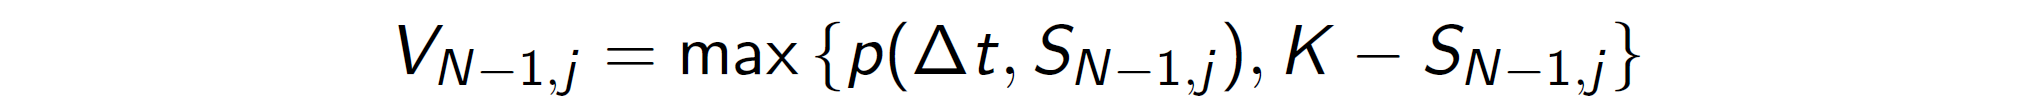

## Richardson Extrapolation
In numerical analysis, Richardson extrapolation is a sequence acceleration method, used to improve the rate of convergence of a sequence of estimates of some value A*. The formula is:
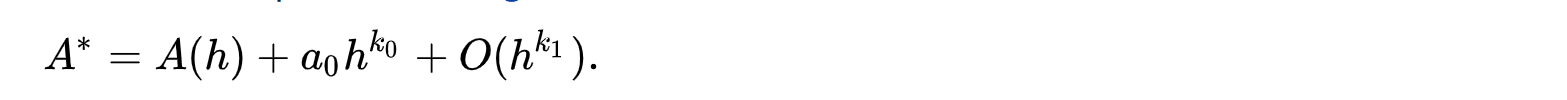

Using the step sizes h and h\t for some constant t, the two formulas for A are:
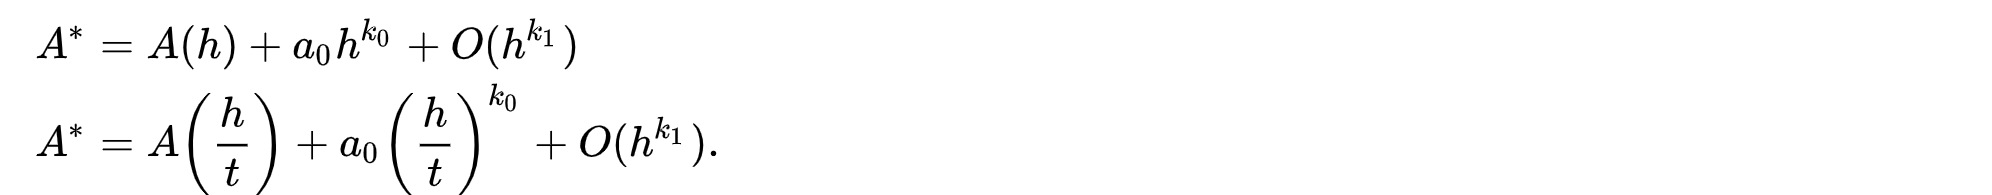

Multiplying the second equation and subtracting the first equation gives:
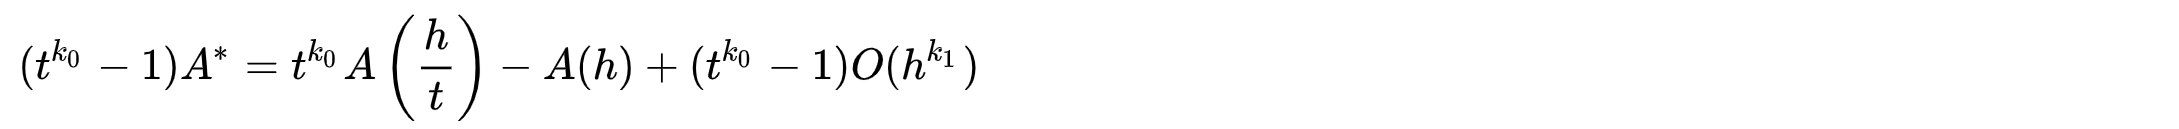
Then we can solve the equation to get A*.
Combined  BBS model and Richardson Extrapolation, the option price we want is A* in the above formula. That is BBSR model.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as si
from sklearn.metrics import mean_squared_error
import time

# BSM Model

In [3]:
def BSM(Put_Call, S_0, X, rfr, vol, t):
    d1 = (np.log(S_0 / X) + (rfr + 0.5 * vol ** 2) * t) / (vol * np.sqrt(t))
    d2 = (np.log(S_0 / X) + (rfr - 0.5 * vol ** 2) * t) / (vol * np.sqrt(t))
    
    if Put_Call == "C":
        opt_price = S_0*si.norm.cdf(d1) - X*np.exp(-rfr*t)*si.norm.cdf(d2)
    elif Put_Call == "P":
        opt_price = X*np.exp(-rfr*t)*si.norm.cdf(-d2) - S_0*si.norm.cdf(-d1)
    
    return opt_price

# BBS Model

In [4]:
def BBS(Put_Call, n, S_0, X, rfr, vol, t):  #rfr is risk free rate, vol is volatility
    deltaT = t/n 
    u = np.exp(vol*np.sqrt(deltaT))
    d = 1./u
    R = np.exp(rfr*deltaT)
    p = (R-d)/(u-d)
    q = 1-p     
    
    # simulating the underlying price paths
    S = np.zeros((n+1,n+1))
    S[0,0] = S_0
    for i in range(1,n+1):
        S[i,0] = S[i-1,0]*u
        for j in range(1,i+1):
            S[i,j] = S[i-1,j-1]*d
    
    # option value at final node   
    V = np.zeros((n+1,n+1)) # V[i,j] is the option value at node (i,j)
    for j in range(n+1):
        if Put_Call=="C":
            V[n,j] = max(0, S[n,j]-X)
        elif Put_Call=="P":
            V[n,j] = max(0, X-S[n,j])
    for j in range(n):
        V[n-1,j] = BSM(Put_Call, S[n-1,j], X, rfr, vol, t/n)
            
   
    for i in range(n-2,-1,-1):
        for j in range(i+1):
            if Put_Call=="P":
                V[i,j] = max(0, X-S[i,j], 1/R*(p*V[i+1,j]+q*V[i+1,j+1]))
            elif Put_Call=="C":
                V[i,j] = max(0, S[i,j]-X, 1/R*(p*V[i+1,j]+q*V[i+1,j+1]))
        opt_price = V[0,0]
        
    return opt_price

# BBSR Model

In [5]:
def BBSR(Put_Call, n, S_0, X, rfr, vol, t): 
    opt_price = 2*BBS(Put_Call, n, S_0, X, rfr, vol, t) \
        - BBS(Put_Call, int(n/2), S_0, X, rfr, vol, t)
    
    return opt_price

# Example

In [6]:
S_0 = 100
rfr = 0.05
vol = 0.3
X = 90
t = 0.5


v_BBSR = BBSR("P", 1000, S_0, X, rfr, vol, t)

v_BBS = BBS("P", 1000, S_0, X, rfr, vol, t)

print(v_BBSR, v_BBS)

3.345395944289011 3.345942622469239
